# Laplacian associative memory (LAM)

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

In [73]:
import os, requests, gzip, hashlib
import numpy as np
import matplotlib.pyplot as plt

In [74]:
def fetch(url):
    filepath = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(filepath):
        with open(filepath, 'rb') as f:
            data = f.read()
    else:
        with open(filepath, 'wb') as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

In [75]:
x = fetch('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')[0x10:]

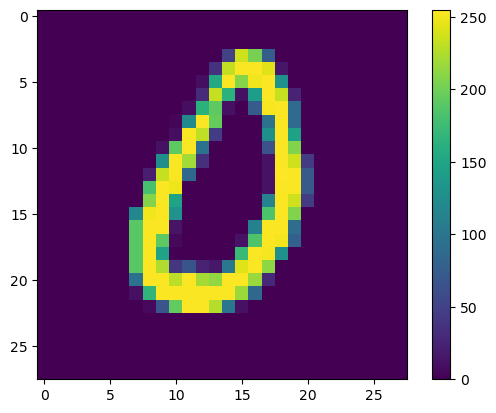

In [76]:
idx = 666

plt.imshow(x.reshape(-1, 28, 28, 1)[idx])
plt.colorbar()

In [77]:
class hopfield:
    def __init__(self, data):

        # Build network
        self.memory = np.array(data)
        self.neurons = self.memory.shape[1] # Number of neurons/dipoles in a network
        self.weights = np.zeros((self.neurons, self.neurons)) # n^2 weight matrix
        self.energies = [] # Malloc energy array

        self.i = np.random.randint(-2,2,(self.neurons, 1)) # Initial state
        self.state = self.i.copy()

    def network_learning(self):
        self.weights = self.memory.T @ self.memory # Weighted hebbian lattice
        # self.weights = (1 / self.weights.shape[0]) * (self.memory.T @ self.memory)
        # np.fill_diagonal(self.weights, 0) # Symmetric weight between neurons i and j

    def update(self, n_update):
        for n in range(n_update):
            self.rand_idx = np.random.randint(0, self.neurons) # Select random units
            self.idx_activation = np.dot(self.weights[self.rand_idx, :], self.state)

            # Binary-threshold output function (Spin/Flip)
            if self.idx_activation > 0:
                self.state[self.rand_idx] = 1
            else:
                self.state[self.rand_idx] = -1

    def compute_energy(self):
        self.energy = -0.5 * np.dot(np.dot(self.state.T, self.weights), self.state)
        self.energies.append(self.energy)

In [78]:
x = x.reshape((-1,784)) # 60000, 784
x_bin = np.where(x > 20, 1,-1) # Binary dipole

memory = np.array([x_bin[idx]])

In [79]:
net = hopfield(memory)
net.network_learning()

In [80]:
steps = 200
n_units = 32

for i in range(steps):
    net.update(n_units)
    net.compute_energy()

(Text(0.5, 0, 'Time'), Text(0, 0.5, 'Energy'))

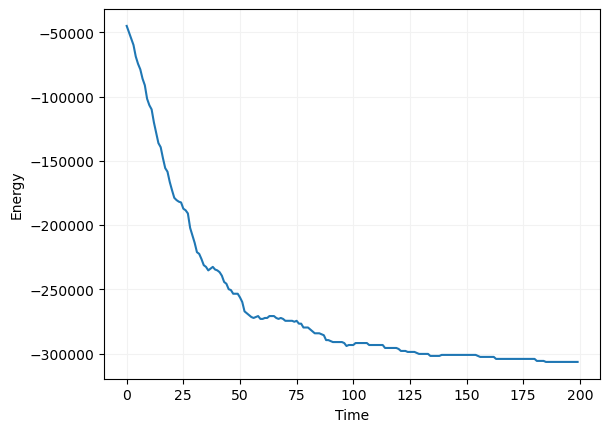

In [81]:
x = np.arange(len(net.energies))
y = np.array(net.energies).squeeze()

plt.plot(x,y)
plt.grid(axis='both', color='0.95')
plt.xlabel('Time'), plt.ylabel('Energy')

[]

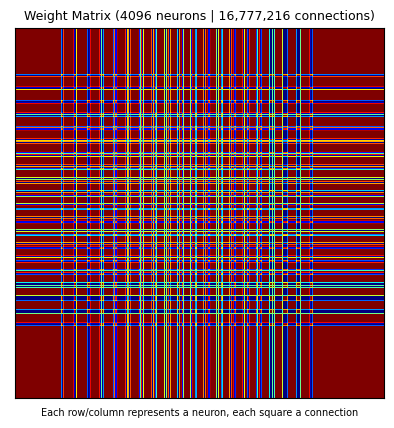

In [82]:
plt.imshow(net.weights, cmap='jet')

plt.title("Weight Matrix (4096 neurons | 16,777,216 connections)", fontsize=9)
plt.xlabel("Each row/column represents a neuron, each square a connection", fontsize=7)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

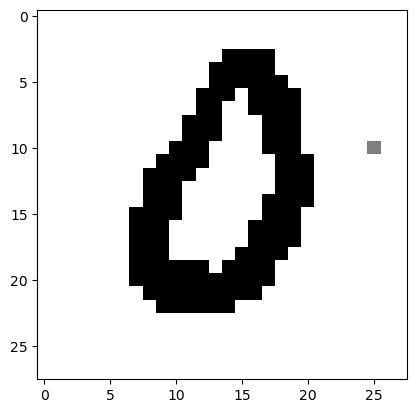

In [83]:
plt.imshow(net.state.reshape(28,28), cmap='binary')